<a href="https://colab.research.google.com/github/SatioO/DL_Practices/blob/master/DeConvNet_with_TF_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

In [0]:
import numpy as np
import tensorflow as tf
import os
import tensorflow.keras as keras

In [0]:
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

# dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [0]:
# !tar -xvf "/root/tensorflow_datasets/annotations.tar.gz"

images_path_dir = os.path.join("/root/tensorflow_datasets", "images")
annotations_path_dir = os.path.join("/root/tensorflow_datasets", "annotations")

train_list_file = os.path.join(annotations_path_dir, "trainval.txt")
test_list_file = os.path.join(annotations_path_dir, "test.txt")

OUTPUT_CHANNELS = 3
DROPOUT_RATE = 0.4

TRAIN_LENGTH = 3800
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

IMG_WIDTH = 224
IMG_HEIGHT = 224

In [0]:
def data_generator(file_path):
    with tf.io.gfile.GFile(file_path, "r") as images_list:
        for line in images_list:
            image_name, label, species, _ = line.strip().split(" ")

            trimaps_dir_path = os.path.join(annotations_path_dir, "trimaps")

            trimap_name = image_name + ".png"
            image_name += ".jpg"
            label = int(label) - 1
            species = int(species) - 1

            record = {
                "image": os.path.join(images_path_dir, image_name),
                "label": int(label),
                "species": species,
                "file_name": image_name,
                "segmentation_mask": os.path.join(trimaps_dir_path, trimap_name)
            }
            
            yield os.path.join(images_path_dir, image_name), os.path.join(trimaps_dir_path, trimap_name)

In [0]:
train_ds = tf.data.Dataset.from_generator(data_generator, output_types=(tf.string, tf.string), args=[train_list_file])
test_ds = tf.data.Dataset.from_generator(data_generator, output_types=(tf.string, tf.string), args=[test_list_file])

In [0]:
def normalize(input_image, input_mask):
    input_image = tf.image.per_image_standardization(input_image)
    input_mask -= 1
    return input_image, input_mask

def load_image(img_path, mask_path):
    input_image = tf.io.read_file(img_path)
    input_image = tf.image.decode_jpeg(input_image, channels = 3)
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = tf.image.resize(input_image, (IMG_HEIGHT, IMG_WIDTH))
    
    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_png(input_mask, channels = 1)
    input_mask = tf.image.resize(input_mask, (IMG_HEIGHT, IMG_WIDTH))
    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

train = train_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(load_image)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

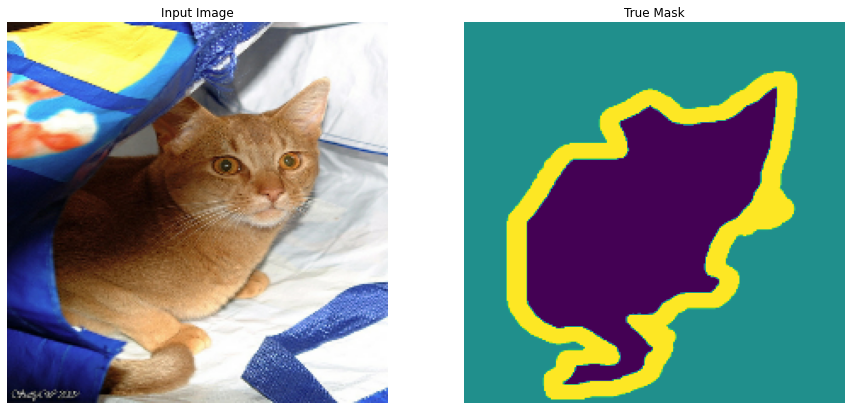

In [10]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [0]:
class MaxUnpoolWithArgmax(keras.layers.Layer):
  def __init__(self, pooling_argmax, stride = [1, 2, 2, 1], **kwargs):
    self.pooling_argmax = pooling_argmax    
    self.stride = stride
    super(MaxUnpoolWithArgmax, self).__init__(**kwargs)
  
  def build(self, input_shape):
    super(MaxUnpoolWithArgmax, self).build(input_shape)
  
  def call(self, inputs):
    input_shape = tf.cast(tf.shape(inputs), tf.int64)
    output_shape = self.compute_output_shape(input_shape)
    
    argmax = self.pooling_argmax
    one_like_mask = tf.ones_like(argmax)
    # create batches of ones - for eg. (BATCH_SIZE, 1, 2, FILTER_SIZE)
    batch_range = tf.reshape(tf.range(start=0, limit=input_shape[0], dtype=tf.int64), (input_shape[0], 1, 1, 1))
    b = one_like_mask * batch_range

    y = argmax // (output_shape[2] * output_shape[3])
    x = argmax % (output_shape[2] * output_shape[3]) // output_shape[3]
    # create filter depth of ones - for eg. (BATCH_SIZE, 1, 2, FILTER_SIZE)
    feature_range = tf.range(start=0, limit=output_shape[3], dtype=tf.int64)
    f = one_like_mask * feature_range
    # gets size of the total elements
    updates_size = tf.size(inputs)
    indices = tf.transpose(tf.reshape(tf.stack([b, y, x, f]), [4, updates_size]))
    values = tf.reshape(inputs, [updates_size])
    return tf.scatter_nd(indices, values, output_shape)

    return inputs

  def compute_output_shape(self, input_shape):
    return (input_shape[0], input_shape[1] * 2, input_shape[2] * 2, input_shape[3])

def build_conv2D_block(inputs, kernel_depth, kernel_size, padding, block, size):
  for b in range(1, size + 1):
    if b == 1:
      e = keras.layers.Conv2D(kernel_depth, kernel_size, padding=padding, name=f"conv-{block}-{b}", use_bias=False)(inputs)
    else:
      e = keras.layers.Conv2D(kernel_depth, kernel_size, padding=padding, name=f"conv-{block}-{b}", use_bias=False)(e)
    
    e = keras.layers.BatchNormalization(name=f"batchnorm-{block}-{b}")(e)
    e = keras.layers.ReLU(name=f"relu-{block}-{b}")(e)

  return e

def build_deconv2D_block(inputs, kernel_depth, kernel_size, padding, block, size):
  for b in range(1, size + 1):
    if b == 1:
      x = keras.layers.Conv2DTranspose(kernel_depth, kernel_size, use_bias=False, padding=padding, name=f"deconv-{block}-{b}")(inputs)
    else:
      x = keras.layers.Conv2DTranspose(kernel_depth, kernel_size, use_bias=False, padding=padding, name=f"deconv-{block}-{b}")(x)

    x = keras.layers.BatchNormalization(name=f"batchnorm-deconv{block}-{b}")(x)
    x = keras.layers.ReLU(name=f'relu_deconv{block}-{b}')(x) 

  return x

def max_pool_with_argmax(x):
  return tf.nn.max_pool_with_argmax(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def build_network(input_shape):
  input_data = keras.Input(shape=input_shape)

  # Downsampling through the model
  conv_block_1 = build_conv2D_block(input_data, 64, 3, 'same', 1, 2)
  pool1, pool1_argmax = keras.layers.Lambda(max_pool_with_argmax, name='pool1')(conv_block_1)

  conv_block_2 = build_conv2D_block(pool1, 128, 3, 'same', 2, 2)
  pool2, pool2_argmax = keras.layers.Lambda(max_pool_with_argmax, name='pool2')(conv_block_2)

  conv_block_3 = build_conv2D_block(pool2, 256, 3, 'same', 3, 3)
  pool3, pool3_argmax = keras.layers.Lambda(max_pool_with_argmax, name='pool3')(conv_block_3)

  conv_block_4 = build_conv2D_block(pool3, 512, 3, 'same', 4, 3)
  pool4, pool4_argmax = keras.layers.Lambda(max_pool_with_argmax, name='pool4')(conv_block_4)

  conv_block_5 = build_conv2D_block(pool4, 512, 3, 'same', 5, 3)
  pool5, pool5_argmax = keras.layers.Lambda(max_pool_with_argmax, name='pool5')(conv_block_5)

  # MiddleLayer Representation
  conv_block_6 = build_conv2D_block(pool5, 512, 7, 'valid', 6, 1)
  conv_block_7 = build_conv2D_block(conv_block_6, 512, 1, 'valid', 7, 1)

  # Upsampling and establishing the skip connections
  x = MaxUnpoolWithArgmax(pool5_argmax, name='unpool5')(conv_block_7)
  x.set_shape(pool5.get_shape())
  x = build_deconv2D_block(x, 512, 3, 'same', 5, 3) 

  x = MaxUnpoolWithArgmax(pool4_argmax, name='unpool4')(x)
  x.set_shape(conv_block_4.get_shape())
  x = build_deconv2D_block(x, 512, 3, 'same', 4, 3)

  x = MaxUnpoolWithArgmax(pool3_argmax, name='unpool3')(x)
  x.set_shape(conv_block_3.get_shape())
  x = build_deconv2D_block(x, 256, 3, 'same', 3, 3)

  x = MaxUnpoolWithArgmax(pool2_argmax, name='unpool2')(x)
  x.set_shape(conv_block_2.get_shape())
  x = build_deconv2D_block(x, 128, 3, 'same', 2, 2)
  
  x = MaxUnpoolWithArgmax(pool1_argmax, name='unpool1')(x)
  x.set_shape(conv_block_1.get_shape())
  x = build_deconv2D_block(x, 64, 3, 'same', 1, 2)
  
  output = keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 1, activation='softmax', padding='same', name='output')(x)

  return keras.Model(input_data, output)